<a href="https://colab.research.google.com/github/Aiz782/PCI/blob/main/Japan_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


Mounted at /content/drive


,Value
TIME,
1960-01-01,18.972569
1961-01-01,19.991104
1962-01-01,21.357584
1963-01-01,22.790017
1964-01-01,23.656126
...,...
2017-01-01,103.963790
2018-01-01,104.992090
2019-01-01,105.484268


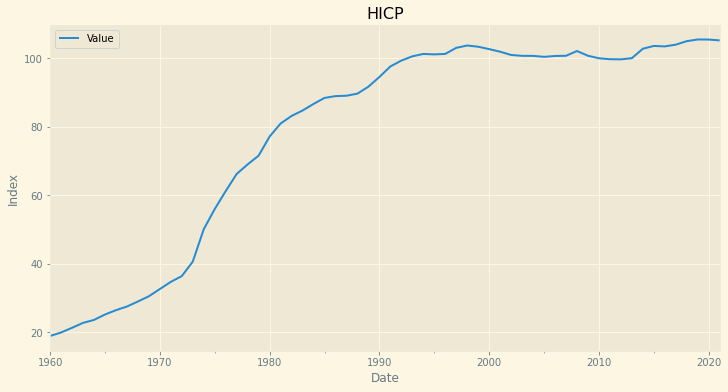

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('Solarize_Light2')
from pylab import rcParams

from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv('/content/drive/MyDrive/Japandata 1 c')
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import cufflinks
df=df.dropna()
df.rename(columns = {'Date':'TIME','CPI':'Value'}, inplace = True)
df.drop(['Year'], inplace=True, axis=1)
df['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df['TIME'] =  pd.to_datetime(df['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df = df.set_index(['TIME'])

df['Value'] = pd.to_numeric(df['Value'],errors = 'coerce')
rcParams['figure.figsize'] = 12, 6
df.plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.title("HICP")
df

In [ ]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df.Value)


Test Statistic                 -2.302668
p-value                         0.171109
#Lags Used                      1.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64

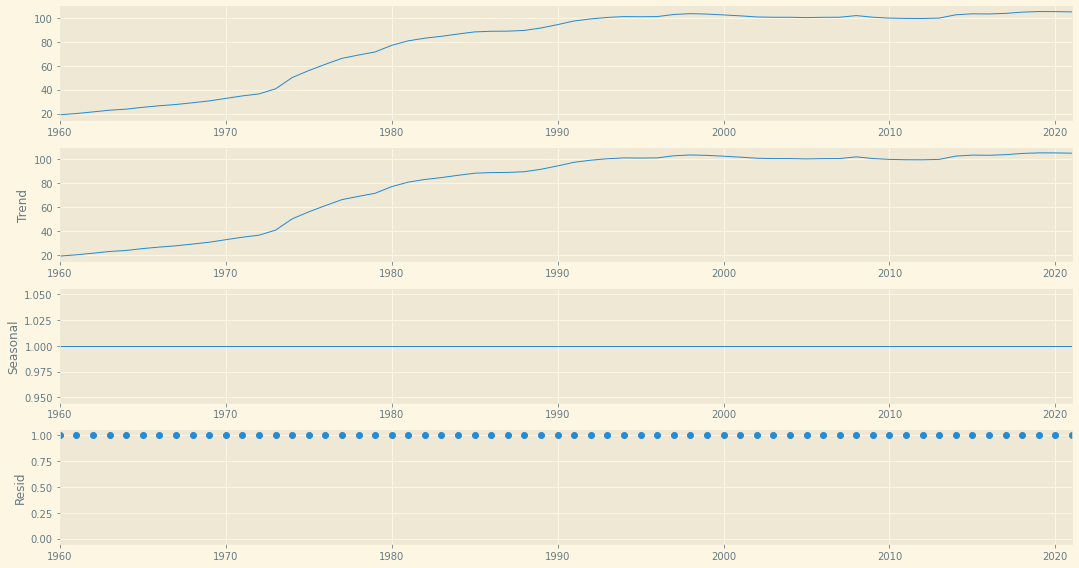

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')


rcParams['figure.figsize'] = 15, 8
plt.rc('lines', linewidth=1, color='r')

fig = result.plot()

In [ ]:
from pmdarima.arima import auto_arima

results = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=244.870, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=190.312, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=205.088, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=210.008, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=192.104, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=192.053, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=235.785, Time=0.10 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=192.220, Time=0.34 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=192.157, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=208.333, Time=0.11 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=194.248, Time=0.32 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=19

In [ ]:
results.aic()

190.3124586981852

In [ ]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1,1 ,0 ),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                   62
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -92.156
Date:                            Fri, 10 Feb 2023   AIC                            190.312
Time:                                    12:17:29   BIC                            195.988
Sample:                                01-01-1960   HQIC                           192.466
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7939      0.134      5.911      0.000       0.531       1.057
ar.S.L12      -0.6549      0.052   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



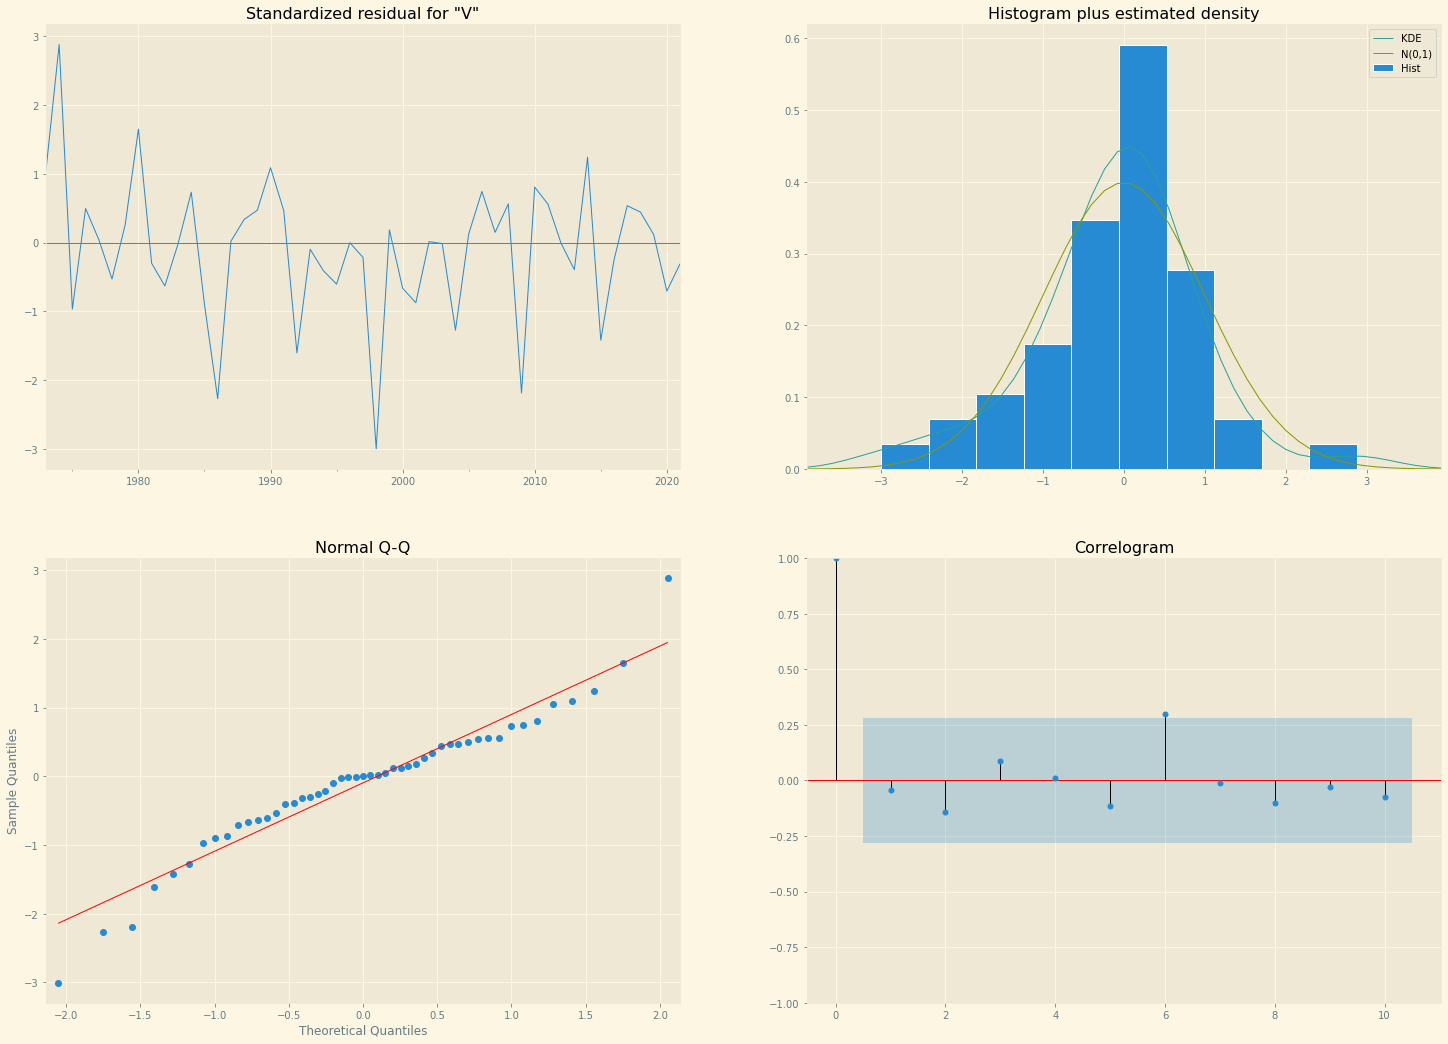

In [ ]:
results.plot_diagnostics(figsize=(25,18))
plt.show()

In [ ]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [ ]:
outliers = find_outliers_IQR(df['Value'])

print('number of outliers: '+ str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

number of outliers: 0
max outlier value: nan
min outlier value: nan


In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
display(pred_ci.tail)

<bound method NDFrame.tail of             lower Value  upper Value   Predicted    Observed  Diff, %%
2019-01-01   102.435092   108.189464  105.312278  105.484268 -0.163048
2020-01-01   103.618796   109.373168  106.495982  105.457901  0.984356
2021-01-01   102.789436   108.543808  105.666622  105.211812  0.432280>

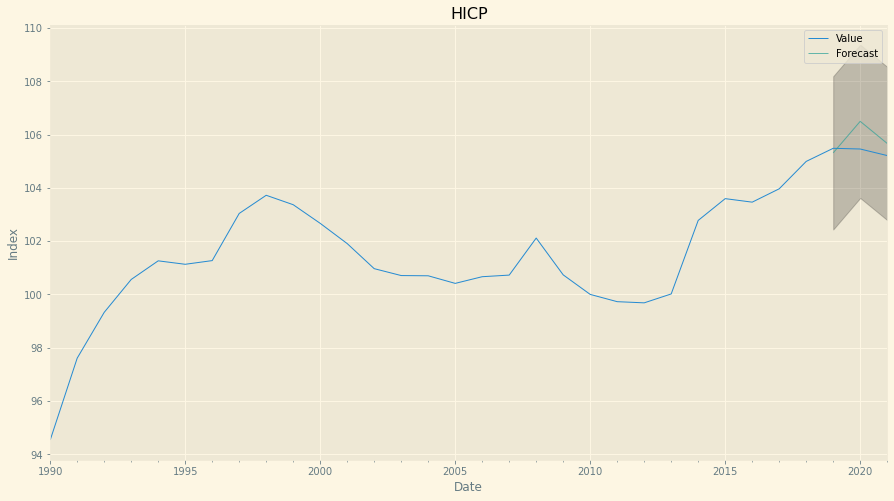

In [ ]:
ax = df['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Index')
plt.title("HICP")
plt.legend()
rcParams['figure.figsize'] = 12, 10
plt.show()

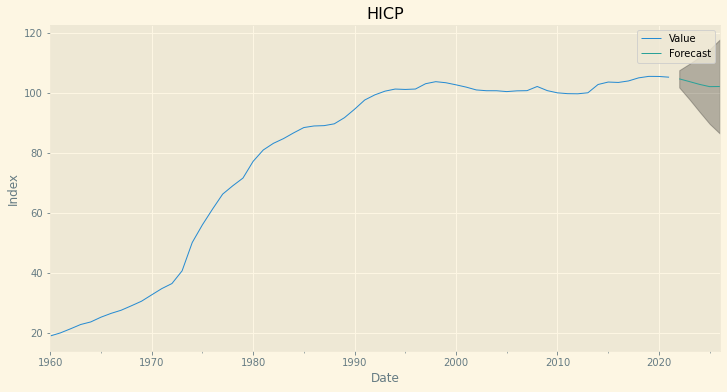

,lower Value,upper Value
2022-01-01,101.791097,107.545469
2023-01-01,97.848299,109.666373
2024-01-01,93.678591,111.960813
2025-01-01,89.644761,114.492581
2026-01-01,86.437862,117.786354


In [ ]:
# Get forecast 3 years ahead in future
pred_uc = results.get_forecast(steps=5)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title("HICP")

plt.legend()
plt.show()
display(pred_ci)


Text(0.5, 1.0, 'HICP')

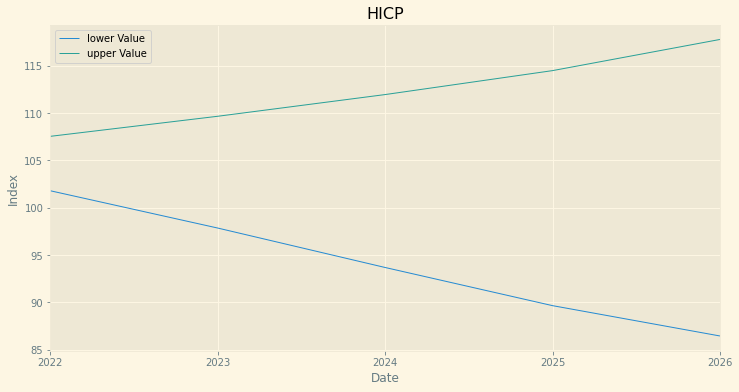

In [ ]:


rcParams['figure.figsize'] = 12, 6
pred_ci.head(11).plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.title("HICP")

In [ ]:

pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2

In [ ]:
display(pred_ci['Mean'])

2022-01-01    104.668283
2023-01-01    103.757336
2024-01-01    102.819702
2025-01-01    102.068671
2026-01-01    102.112108
Freq: AS-JAN, Name: Mean, dtype: float64

Text(0.5, 1.0, 'HICP')

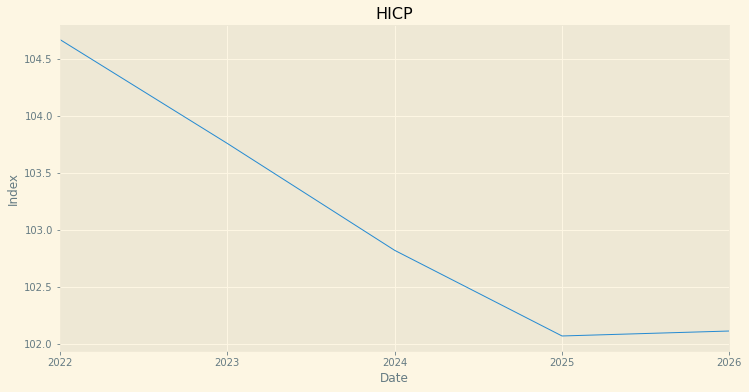

In [ ]:
rcParams['figure.figsize'] = 12, 6
pred_ci['Mean'].head(11).plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.title("HICP")

                     HICP predicted monthly and annual rates of change Jan 2019 to Dec 2019 


Text(0, 0.5, 'HICP annual rate of change')

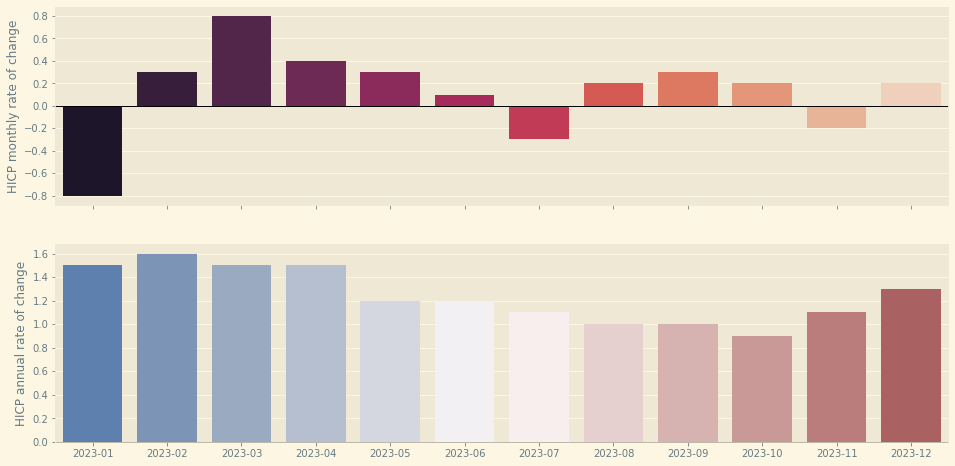

In [ ]:
import seaborn as sns

print("                     HICP predicted monthly and annual rates of change Jan 2019 to Dec 2019 ")
monthly_roc = [-0.8, 0.3, 0.8, 0.4, 0.3, 0.1, -0.3, 0.2, 0.3, 0.2, -0.2, 0.2]
annual_roc = [1.5, 1.6, 1.5, 1.5, 1.2, 1.2, 1.1, 1, 1, 0.9, 1.1, 1.3]
index = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']


f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Generate some sequential data
sns.barplot(x=index, y=monthly_roc, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("HICP monthly rate of change")

# Center the data to make it diverging

sns.barplot(x=index, y=annual_roc, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("HICP annual rate of change")